# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month,isnan, count, when, col, desc, udf, col, sort_array, asc, avg, sum as fsum,countDistinct,max,min,datediff, to_date,date_format,dense_rank,create_map,lit 
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from itertools import chain

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler,StringIndexer

from datetime import datetime as dt
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession \
        .builder \
        .appName("Lucas Sparkify Project") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
spark.sparkContext.getConf().getAll()
path = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
path2 = 's3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json'
user_log = spark.read.json(path)

In [4]:
user_log.printSchema()
#length its the time of the song

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
user_log.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [6]:
#what are the possible pages?
user_log.select('page').drop_duplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [7]:
#what is userAgent
user_log.select('userAgent').drop_duplicates().take(5)

[Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"')]

In [8]:
#what is auth?
user_log.select('auth').drop_duplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [9]:
#what is status?
user_log.select('status').drop_duplicates().show()
user_log.filter(user_log.status==307).select('page').drop_duplicates().take(3)

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



[Row(page='Cancel'), Row(page='Submit Downgrade'), Row(page='Thumbs Down')]

In [10]:
#what is method?
user_log.select('method').drop_duplicates().show()
user_log.filter(user_log.method == 'PUT').select('page').drop_duplicates().collect()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Submit Registration'),
 Row(page='Login'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Submit Upgrade')]

In [11]:
#Checking the types of  gender and if there are any nan values
user_log.select('gender').dropDuplicates().show()

+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+



In [12]:
user_log.filter(user_log.sessionId == 28).select('userId','itemInSession','page','ts','auth','registration').sort('ts').collect()

[Row(userId='29', itemInSession=0, page='NextSong', ts=1538438103000, auth='Logged In', registration=1536988041000),
 Row(userId='29', itemInSession=1, page='NextSong', ts=1538438349000, auth='Logged In', registration=1536988041000),
 Row(userId='29', itemInSession=2, page='Settings', ts=1538438387000, auth='Logged In', registration=1536988041000),
 Row(userId='29', itemInSession=3, page='NextSong', ts=1538438607000, auth='Logged In', registration=1536988041000),
 Row(userId='29', itemInSession=4, page='Upgrade', ts=1538438619000, auth='Logged In', registration=1536988041000),
 Row(userId='29', itemInSession=5, page='NextSong', ts=1538438807000, auth='Logged In', registration=1536988041000),
 Row(userId='29', itemInSession=6, page='Roll Advert', ts=1538438862000, auth='Logged In', registration=1536988041000),
 Row(userId='29', itemInSession=7, page='NextSong', ts=1538439032000, auth='Logged In', registration=1536988041000),
 Row(userId='29', itemInSession=8, page='NextSong', ts=1538439

In [13]:
#auth Guest and Logged Out dosent show userId and are not users to be analysed
user_log = user_log.filter(~user_log.auth.isin(['Guest','Logged Out']))

In [14]:
#Creating a more visual date column
get_date = udf(lambda x: dt.fromtimestamp(x / 1000.0).strftime("%d/%m/%Y") )

user_log = user_log.withColumn("date", to_date(get_date(user_log.ts),'dd/mm/yyyy'))

In [15]:
windowval = Window.partitionBy("userId").orderBy(desc("date")).rangeBetween(Window.unboundedPreceding, 0)

user_log = user_log.withColumn("lastSession", max("date").over(windowval)) \
                   .withColumn("daysFromLastSession", datediff(col('lastSession'), col('date')))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [16]:
make_binominal = udf(lambda user: 0 if user == None else 1, IntegerType())

cancelled_users = user_log.filter(user_log.page=='Cancellation Confirmation') \
    .select('userId') \
    .dropDuplicates() \
    .withColumnRenamed('userId', 'Cancelled')

user_log = user_log.join(cancelled_users, cancelled_users.Cancelled == user_log.userId, how='left') \
    .withColumn('Cancelled',make_binominal(col('Cancelled')))


In [17]:
n_userIds = user_log.select('userId').dropDuplicates().count()
print("The number of unique Users ids is: ",n_userIds)

The number of unique Users ids is:  225


In [18]:
cSplit = user_log.select('Cancelled', 'userId') \
                               .dropDuplicates() \
                               .groupBy('Cancelled').count() \
                               .toPandas()
cancelled_u = cSplit.loc[cSplit.Cancelled==1]["count"].values[0]

active_u = cSplit.loc[cSplit.Cancelled==0]["count"].values[0]

print("The number of cancelled users is ",
      cancelled_u," which stands for ", cancelled_u/n_userIds, " users",
      "\nThe number of active users is ",
      active_u," which stands for ", active_u/n_userIds, " users.")

The number of cancelled users is  52  which stands for  0.231111111111  users 
The number of active users is  173  which stands for  0.768888888889  users.


In [33]:
#Comparing Itens in Sessions, Song Variety and Song quantity
user_log.filter(user_log.song.isNotNull()) \
    .groupBy('Cancelled', 'userId','sessionId').agg(max('itemInSession'),countDistinct('song'),count('song')) \
    .groupby('Cancelled','userId').avg() \
    .groupby('Cancelled').avg() \
    .select('Cancelled',col('avg(avg(max(itemInSession)))').alias("Average Itens per Session"),col('avg(avg(count(DISTINCT song)))').alias("Average Distinct Songs Lisned to"),col('avg(avg(count(song)))').alias("Avarage total songs played")) \
    .show()

+---------+-------------------------+--------------------------------+--------------------------+
|Cancelled|Average Itens per Session|Average Distinct Songs Lisned to|Avarage total songs played|
+---------+-------------------------+--------------------------------+--------------------------+
|        1|        79.57481393327174|               62.53449286816023|          63.5371525780952|
|        0|        89.63262543730534|               71.59624227175094|         72.96967249911359|
+---------+-------------------------+--------------------------------+--------------------------+



In [34]:
#Friends Added and Songs Reactions influence users churn?
user_log.groupBy('Cancelled','userId','page').count() \
    .groupby('Cancelled','page').avg() \
    .where(user_log.page.isin(['Thumbs Up','Add Friend','Thumbs Down'])) \
    .sort('page','Cancelled').select('Cancelled','page',col('avg(count)').alias('Number of Interactions')).show()

+---------+-----------+----------------------+
|Cancelled|       page|Number of Interactions|
+---------+-----------+----------------------+
|        0| Add Friend|     22.47530864197531|
|        1| Add Friend|    14.454545454545455|
|        0|Thumbs Down|    13.225806451612904|
|        1|Thumbs Down|    10.333333333333334|
|        0|  Thumbs Up|     62.89411764705882|
|        1|  Thumbs Up|                 37.18|
+---------+-----------+----------------------+



In [35]:
#sessions in the last month for normal and churned users

windowval = Window.partitionBy("userId").orderBy(desc("date")).rangeBetween(Window.unboundedPreceding, 0)

user_log.filter(user_log.itemInSession==0) \
    .withColumn("lastSession", max("date").over(windowval)) \
    .withColumn("daysFromLastSession", datediff(col('lastSession'), col('date'))) \
    .where(col('daysFromLastSession')<31) \
    .groupBy('Cancelled','userId').count() \
    .groupBy('Cancelled').mean() \
    .select('Cancelled',col('avg(count)').alias('Number of Sessions')).show()


+---------+------------------+
|Cancelled|Number of Sessions|
+---------+------------------+
|        1|              8.68|
|        0|13.264705882352942|
+---------+------------------+



In [22]:
#avarage days in premium
user_log.filter((user_log.itemInSession==0) & (user_log.Cancelled==1) & (user_log.level=='paid')) \
    .groupBy('userId').agg(min("date"),max("date")) \
    .withColumn("daysInPremiun", datediff(col('max(date)'), col('min(date)'))) \
    .select(avg('daysInPremiun')) \
    .show()

+------------------+
|avg(daysInPremiun)|
+------------------+
|14.441176470588236|
+------------------+



Text(0.5,1,'Cancelled users songs played for Session')

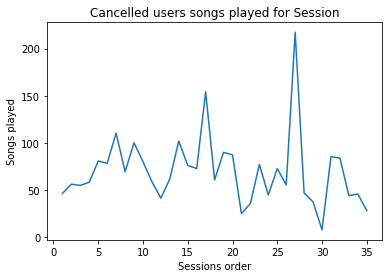

In [23]:
Wrank = Window.partitionBy("UserId").orderBy('SessionId')

songs_per_session = user_log.filter(user_log.page == "NextSong").withColumn("SessionRank", dense_rank().over(Wrank))
songs_per_session = songs_per_session.groupBy('Cancelled','UserId','SessionRank').count() \
                .groupBy('Cancelled','SessionRank').avg() \
                .toPandas()

c = songs_per_session.loc[songs_per_session.Cancelled==1].sort_values('SessionRank')["avg(count)"]
h = songs_per_session.loc[songs_per_session.Cancelled==1].sort_values('SessionRank')["SessionRank"]
plt.plot(h,c)
plt.xlabel("Sessions order")
plt.ylabel("Songs played")
plt.title("Cancelled users songs played for Session")


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [24]:
def SessionsLast30days(originalDataset, modelDataset):
    '''
        This function creates a features with the number of sessions
        an user had whitin the past 30 days
        
        INPUT: originalDataset - original data frame with all the columns 
               modelDataset - the data frame with the other features
        OUTPUT: modelDataset - the data frame with the other features and the new feature

    '''
    
    IdFeature = originalDataset.filter(originalDataset.itemInSession==0) \
        .where(col('daysFromLastSession')<31) \
        .groupBy('userId').count() \
        .withColumnRenamed('count','SessionsLast30days')
    
    modelDataset = modelDataset.join(IdFeature,'userId', "left")
    
    return modelDataset

In [25]:
def AvgSongsPlayes (originalDataset, modelDataset):
    '''
        This function creates a features that represents avarage songs 
        played by Session
        
        INPUT: originalDataset - original data frame with all the columns 
               modelDataset - the data frame with the other features
        OUTPUT: modelDataset - the data frame with the other features and the new feature

    '''
    IdFeature = originalDataset.filter(user_log.song.isNotNull()) \
        .where(col('daysFromLastSession')<8) \
        .groupBy('userId','sessionId').count() \
        .groupby('userId').avg() \
        .select('userId','avg(count)') \
        .withColumnRenamed('avg(count)','Avg_Songs_Played_Session')
    
    modelDataset = modelDataset.join(IdFeature,'userId', "left")
    
    return modelDataset

In [26]:
def SongVariety (originalDataset, modelDataset):
    '''
        This function creates a features that represents the variety of 
        songs a user has
        
        INPUT: originalDataset - original data frame with all the columns 
               modelDataset - the data frame with the other features
        OUTPUT: modelDataset - the data frame with the other features and the new feature


    '''
    IdFeature = originalDataset.groupBy('userId').agg(countDistinct('song')) \
        .withColumnRenamed('count(DISTINCT song)','Song_Varierty')
    
    modelDataset = modelDataset.join(IdFeature,'userId', "left")
    
    return modelDataset

In [41]:
def LikedSongsProportion (originalDataset, modelDataset):
    '''
        This function calculates the ratio of desliked songs for liked songs
        by each user id in his entire expirence in the plataform
        
        INPUT: originalDataset - original data frame with all the columns 
               modelDataset - the data frame with the other features
        OUTPUT: modelDataset - the data frame with the other features and the new feature


    '''
    flag_like = udf(lambda x: 1 if x == 'Thumbs Up' else 0, IntegerType())
    
    flag_deslike = udf(lambda x: 1 if x == 'Thumbs Down' else 0, IntegerType())

    originalDataset = originalDataset.withColumn('Thumbs Up', flag_like('page')) \
        .withColumn('Thumbs Down', flag_deslike('page'))
    
    IdFeature = originalDataset.groupBy('userId').agg(fsum('Thumbs Up'),fsum('Thumbs Down')) \
        .withColumn('ThumbsProportion',col('sum(Thumbs Down)') / col('sum(Thumbs Up)')) \
        .withColumnRenamed('sum(Thumbs Up)','Liked_Songs') \
        .withColumnRenamed('sum(Thumbs Down)','Desliked_Songs')
    
    modelDataset = modelDataset.join(IdFeature,'userId', "left")
    
    return modelDataset

In [28]:
def FriedsAdded (originalDataset, modelDataset):
    '''
        This function calculates the number friends added by the user 
        
        INPUT: originalDataset - original data frame with all the columns 
               modelDataset - the data frame with the other features
        OUTPUT: modelDataset - the data frame with the other features and the new feature


    '''
    flag_friedadd = udf(lambda x: 1 if x == 'Add Friend' else 0, IntegerType())
    
    originalDataset = originalDataset.withColumn('Add Friend', flag_friedadd('page'))
    
    IdFeature = originalDataset.where(col('daysFromLastSession')<8) \
        .groupBy('userId').sum('Add Friend') \
        .withColumnRenamed('sum(Add Friend)','Friends_Added') \
    
    modelDataset = modelDataset.join(IdFeature,'userId', "left")
    
    return modelDataset

In [29]:
def DaysInPremium (originalDataset, modelDataset):
    '''
        This function calculates the number of days a user stayed as a
        Premium user
        
        INPUT: originalDataset - original data frame with all the columns 
               modelDataset - the data frame with the other features
        OUTPUT: modelDataset - the data frame with the other features and the new feature


    '''
    originalDataset = originalDataset.filter(user_log.level=='paid') \
        .groupBy('userId') \
        .agg(max('ts'),min('ts')) \
        .withColumn('PremiumTime', col('max(ts)').cast("long") - col('min(ts)').cast("long") ) \
        .withColumn('Days_In_Premium', col('PremiumTime')/(24*3600*1000)) \
        .select('userId','Days_In_Premium')
        
    modelDataset = modelDataset.join(originalDataset,'userId', "left")
    
    modelDataset = modelDataset.fillna(0)
    
    return modelDataset

In [30]:
def DaysInSparkfy (originalDataset, modelDataset):
    '''
        This function calculates the number of days a user stayed as a
        Premium user
        
        INPUT: originalDataset - original data frame with all the columns 
               modelDataset - the data frame with the other features
        OUTPUT: modelDataset - the data frame with the other features and the new feature


    '''
    originalDataset = originalDataset.groupBy('userId') \
        .agg(max('ts'),max('registration')) \
        .withColumn('User_Time', col('max(ts)').cast("long") - col('max(registration)').cast("long") ) \
        .withColumn('DaysInSparkfy', col('User_Time')/(24*3600*1000)) \
        .select('userId','DaysInSparkfy')
        
    modelDataset = modelDataset.join(originalDataset,'userId', "left")
    
    return modelDataset

In [42]:
ModelData = user_log.select('userId','Cancelled','gender').dropDuplicates()

indexer = StringIndexer(inputCol="gender", outputCol="genderIndexed",handleInvalid="skip")
ModelData = indexer.fit(ModelData).transform(ModelData)

#avarage itens in sessions
ModelData = AvgSongsPlayes(user_log,ModelData)

#number of differente musics played
ModelData = SongVariety(user_log,ModelData)

#liked and desliked songs
ModelData = LikedSongsProportion(user_log,ModelData)

#Friends added
ModelData = FriedsAdded(user_log,ModelData)

#Premium Time
ModelData = DaysInPremium(user_log,ModelData)

#Sesions in the last 30 days
ModelData = SessionsLast30days(user_log,ModelData)

#Days since registration
ModelData = DaysInSparkfy(user_log,ModelData)

ModelData = ModelData.fillna(0)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [43]:
y_collect = ModelData.select("Cancelled").groupBy("Cancelled").count().collect()
unique_y = [x["Cancelled"] for x in y_collect]
total_y = 225 #sum([x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]

class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}

In [44]:
features = [ "Avg_Songs_Played_Session","genderIndexed", "ThumbsProportion", "Friends_Added", "Days_In_Premium","SessionsLast30days","DaysInSparkfy"]

assembler = VectorAssembler(inputCols=features, outputCol="features")

ModelData = assembler.transform(ModelData)

mapping_expr = create_map([lit(x) for x in chain(*class_weights_spark.items())])

ModelData = ModelData.withColumn("weight", mapping_expr.getItem(col("Cancelled")))

rest, validation = ModelData.randomSplit([0.8, 0.2], seed=42)


In [45]:
#lr = LogisticRegression(labelCol='Cancelled', maxIter=10, regParam=0.3, elasticNetParam=0.8)
#lrModel = lr.fit(rest)

gbt = GBTClassifier(labelCol="Cancelled", featuresCol="features", maxIter=30)
lrModel = gbt.fit(rest)

results = lrModel.transform(validation)

n_labes = results.count()
tp = results.filter((results.Cancelled == 1) & (results.prediction==1)).count()
tn = results.filter((results.Cancelled == 0) & (results.prediction==0)).count()
fn = results.filter((results.Cancelled == 1) & (results.prediction==0)).count()
fp = results.filter((results.Cancelled == 0) & (results.prediction==1)).count()

precision = tp/(tp+fp)

recall = tp/(tp+fn)

correct_laels = tp+tn

F1_score = 2*(recall * precision) / (recall + precision)

print("Number of correcet labes: {}\nNumber of labels: {}\nAccuracy: {}".format(correct_laels,n_labes,(tp+tn)/n_labes))

print("F1_score: {}\nprecision: {}\nrecall: {}".format(F1_score,precision,recall))

print("Number of false negatives: {}".format(fn))
print("Number of false positive: {}".format(fp))
print("Number of true negatives: {}".format(tn))
print("Number of true positive: {}".format(tp))

Number of correcet labes: 26
Number of labels: 34
Accuracy: 0.7647058823529411
F1_score: 0.5555555555555556
precision: 0.5
recall: 0.625
Number of false negatives: 3
Number of false positive: 5
Number of true negatives: 21
Number of true positive: 5


In [46]:
lr = LogisticRegression(labelCol='Cancelled',weightCol="weight")
lrModel = lr.fit(rest)

results = lrModel.transform(validation)

n_labes = results.count()
tp = results.filter((results.Cancelled == 1) & (results.prediction==1)).count()
tn = results.filter((results.Cancelled == 0) & (results.prediction==0)).count()
fn = results.filter((results.Cancelled == 1) & (results.prediction==0)).count()
fp = results.filter((results.Cancelled == 0) & (results.prediction==1)).count()

precision = tp/(tp+fp)

recall = tp/(tp+fn)

correct_laels = tp+tn

F1_score = 2*(recall * precision) / (recall + precision)

print("Number of correcet labes: {}\nNumber of labels: {}\nAccuracy: {}".format(correct_laels,n_labes,(tp+tn)/n_labes))

print("F1_score: {}\nprecision: {}\nrecall: {}".format(F1_score,precision,recall))

print("Number of false negatives: {}".format(fn))
print("Number of false positive: {}".format(fp))
print("Number of true negatives: {}".format(tn))
print("Number of true positive: {}".format(tp))

Number of correcet labes: 27
Number of labels: 34
Accuracy: 0.7941176470588235
F1_score: 0.631578947368421
precision: 0.5454545454545454
recall: 0.75
Number of false negatives: 2
Number of false positive: 5
Number of true negatives: 21
Number of true positive: 6


In [47]:
lr = LogisticRegression(labelCol='Cancelled')
lrModel = lr.fit(rest)

results = lrModel.transform(validation)

n_labes = results.count()
tp = results.filter((results.Cancelled == 1) & (results.prediction==1)).count()
tn = results.filter((results.Cancelled == 0) & (results.prediction==0)).count()
fn = results.filter((results.Cancelled == 1) & (results.prediction==0)).count()
fp = results.filter((results.Cancelled == 0) & (results.prediction==1)).count()

precision = tp/(tp+fp)

recall = tp/(tp+fn)

correct_laels = tp+tn

F1_score = 2*(recall * precision) / (recall + precision)

print("Number of correcet labes: {}\nNumber of labels: {}\nAccuracy: {}".format(correct_laels,n_labes,(tp+tn)/n_labes))

print("F1_score: {}\nprecision: {}\nrecall: {}".format(F1_score,precision,recall))

print("Number of false negatives: {}".format(fn))
print("Number of false positive: {}".format(fp))
print("Number of true negatives: {}".format(tn))
print("Number of true positive: {}".format(tp))

Number of correcet labes: 28
Number of labels: 34
Accuracy: 0.8235294117647058
F1_score: 0.4
precision: 1.0
recall: 0.25
Number of false negatives: 6
Number of false positive: 0
Number of true negatives: 26
Number of true positive: 2
